### Install Dependencies

In [272]:
try:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path
    from datetime import datetime
    import warnings
    warnings.filterwarnings("ignore")
except ImportError as e:
    # If any library is missing, install the required packages from requirements.txt file in directory
    %pip install -r requirements.txt

    # After installation, import the libraries again
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path
    from datetime import datetime
    import warnings
    warnings.filterwarnings("ignore")

In [216]:
# Initialize Faker to generate fake data
fake = Faker()

# number of rows to generate for the dataset
num_rows = 1000

# directory to save the generated data
data_dir = Path('.')

# categories and corresponding product names
categories_and_products = {
    'electronics': ['TV', 'Laptop', 'Smartphone', 'Headphones', 'Camera', 'Smartwatch', 'Tablet', 'Bluetooth Speaker', 'Game Console', 'Printer'],
    'fashion': ['T-shirt', 'Jeans', 'Jacket', 'Dress', 'Sweater', 'Sneakers', 'Shirt', 'Hat', 'Socks', 'Scarf'],
    'home': ['Couch', 'Dining Table', 'Chair', 'Coffee Table', 'Lamp', 'Desk', 'Bookshelf', 'Air Conditioner', 'Curtains', 'Toaster'],
    'sports': ['Soccer Ball', 'Basketball', 'Tennis Racket', 'Baseball Bat', 'Yoga Mat', 'Golf Club', 'Dumbbells', 'Cycling Helmet', 'Running Shoes'],
    'beauty': ['Shampoo', 'Conditioner', 'Face Cream', 'Lipstick', 'Mascara', 'Nail Polish', 'Perfume', 'Body Lotion', 'Hair Dryer', 'Makeup Brush']
}

# Function to generate random dates between 2023 and September 2024
def generate_random_date(start_date, end_date):
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    random_date = start_date + timedelta(days=random_days)
    return random_date

# Function to generate fake order data
def generate_order_data():
    carriers = ['DHL', 'FedEx', 'UPS']
    shipment_statuses = ['pending', 'shipped', 'delivered']
    payment_methods = ['Debit Card', 'Credit Card', 'PayPal']
    
    orders = []
    start_date = datetime(2023, 1, 1)  # Start from January 1, 2023
    end_date = datetime(2024, 9, 30)  # End on September 30, 2024
    
    for _ in range(num_rows):
        order_id = fake.uuid4()
        order_date = generate_random_date(start_date, end_date)
        
        total_price = round(random.uniform(20.0, 500.0), 2)
        quantity = random.randint(1, 5)
        
        # Randomly select a category and product based on that category
        category = random.choice(list(categories_and_products.keys()))
        product_name = random.choice(categories_and_products[category])
        
        # generate random Shipment status
        shipment_status = random.choice(shipment_statuses)
        
        # Rating and review_date should only be assigned if shipment_status is 'delivered'
        rating = None
        review_date = None
        if shipment_status == 'delivered':
            # Rating is a random float between 0 and 5 (e.g., 1.4, 4.8)
            rating = round(random.uniform(0.0, 5.0), 1)
            
            # Review date should be after the order date, but before delivery date
            review_date = generate_random_date(order_date, order_date + timedelta(days=30))
        
        # Shipment date must be after the order date
        shipment_date = generate_random_date(order_date, datetime.now())
        
        # Delivery date must be after the shipment date
        delivery_date = generate_random_date(shipment_date, shipment_date + timedelta(days=15))
        
        # Carrier is randomly chosen
        carrier = random.choice(carriers)
        
        # Payment method is randomly chosen
        payment_method = random.choice(payment_methods)
        
        orders.append([
            order_id, order_date, total_price, quantity, 
            product_name, category, rating, review_date, shipment_date, 
            carrier, delivery_date, shipment_status, payment_method
        ])
    
    return pd.DataFrame(orders, columns=[
        'order_id', 'order_date', 'total_price', 'quantity', 
        'product_name', 'category', 'rating', 'review_date', 
        'shipment_date', 'carrier', 'delivery_date', 'shipment_status', 'payment_method'
    ])

# Generate order data
df = generate_order_data()

# Save the generated orders data as a CSV file with the new name
df.to_csv(data_dir / 'generated_data.csv', index=False)

print("Fake e-commerce order data has been generated and saved as 'generated_data.csv'.")

Fake e-commerce order data has been generated and saved as 'generated_data.csv'.


### Load Datasets

In [862]:
# Define the path to the 'data' directory
data_dir = Path('data')

# Load the CSV files using pathlib to ensure compatibility across platforms
df = pd.read_csv(data_dir / 'generated_data.csv')

### Data Pre Processing

In [874]:
class DataPreprocessor:
    def __init__(self, df):
        """
        Initializes the DataPreprocessor with a DataFrame.
        :param df: Raw input DataFrame
        """
        self.df = df.copy()

    def handle_missing_values(self):
        """Fills or drops missing values."""
        # Drop rows where essential columns are missing
        self.df.dropna(subset=['category', 'order_date', 'total_price', 'quantity'], inplace=True)
        
        # Fill missing category with 'Unknown'
        self.df['category'].fillna('Unknown', inplace=True)
        print("Handled missing values.")

    def format_data(self):
        """Formats columns to allow for analysis"""
        try:
            self.df['order_date'] = pd.to_datetime(self.df['order_date'])
            self.df['quantity'] = pd.to_numeric(self.df['quantity'], errors='coerce')

            # Create the 'revenue' column
            self.df['revenue'] = self.df['total_price'] * self.df['quantity']
        except Exception as e:
            print("Error in formatting:", e)

        # Standardize category names
        self.df['category'] = self.df['category'].str.title()
        print("Formatted data successfully.")

    def remove_duplicates(self):
        """Removes duplicate rows."""
        initial_rows = len(self.df)
        self.df.drop_duplicates(inplace=True)
        print(f"Removed {initial_rows - len(self.df)} duplicate rows.")

    def clean_invalid_data(self):
        """Removes invalid data like negative revenues."""
        invalid_rows = self.df[self.df['revenue'] < 0]
        self.df = self.df[self.df['revenue'] >= 0]
        print(f"Removed {len(invalid_rows)} rows with invalid revenue.")

    def preprocess(self):
        """Runs all preprocessing steps."""
        print("Starting data preprocessing...")
        self.handle_missing_values()
        self.format_data()
        self.remove_duplicates()
        self.clean_invalid_data()
        print("Data preprocessing completed.")
        return self.df

In [875]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(df)

# Preprocess the dataset and save the cleaned DataFrame
df = preprocessor.preprocess()

Starting data preprocessing...
Handled missing values.
Formatted data successfully.
Removed 0 duplicate rows.
Removed 0 rows with invalid revenue.
Data preprocessing completed.


### Sales Data Filter

In [876]:
class Filter:
    def __init__(self, df):
        """
        Initializes the Filter class.
        :param df: DataFrame containing sales data.
        """
        self.df = df

    def filter_current_ytd_data(self):
        """
        Filters the sales data for the current year up to the current date.
        :return: DataFrame containing current YTD data.
        """
        current_year = 2024
        today = datetime.now().date()
        ytd_data = self.df[
            (self.df['order_date'].dt.year == current_year) &
            (self.df['order_date'].dt.date <= today)
        ]
        return ytd_data
    
    def filter_ly_data(self):
        """
        Filters the sales data for the last year (full year).
        :return: DataFrame containing LY data.
        """
        last_year = 2023
        ly_data = self.df[self.df['order_date'].dt.year == last_year]
        return ly_data

### Sales Tracking Feature

In [877]:
class SalesTracker:
    def __init__(self, df):
        """
        Initialize the SalesTracker class by processing the sales data.
        """
        self.sales_data = df
        self.feature = Filter(self.sales_data)  # Create Filter class instance for filtering data
    
    def calculate_total_sales_ytd_vs_ly(self):
        """
        Calculates the total revenue for the Year-to-Date (YTD) and Last Year (LY) YTD.
        """
        try:
            # Get filtered data from Filter class
            ytd_data = self.feature.filter_current_ytd_data()
            ly_data = self.feature.filter_ly_data()

            total_sales_ytd = ytd_data['revenue'].sum()
            total_sales_ly_ytd = ly_data['revenue'].sum()

            return total_sales_ytd, total_sales_ly_ytd

        except Exception as e:
            print(f"Error in calculating total sales YTD vs LY: {e}")
            return None, None

    def generate_sales_report(self):
        """
        Generates a pivot table comparing total revenue for Year-to-Date (YTD) and Last Year (LY) YTD sales (up to September).
        """
        try:
            # Initialize Filter class to handle data filtering
            feature = Filter(self.sales_data)

            # Filter data for current YTD
            current_ytd_data = feature.filter_current_ytd_data()

            # Filter data for last year (LY) YTD up to September
            ly_ytd_data = feature.filter_ly_data()
            ly_ytd_data = ly_ytd_data[ly_ytd_data['order_date'].dt.month <= 9]

            # Calculate total sales for current year (YTD) and last year (LY YTD) up to September
            total_sales_ytd = current_ytd_data['revenue'].sum()
            total_sales_ly_ytd = ly_ytd_data['revenue'].sum()

            # Create a DataFrame for the report
            report_data = {
                'Year': ['Current YTD', 'Last YTD'],
                'Total Sales': [total_sales_ytd, total_sales_ly_ytd]
            }
            report_df = pd.DataFrame(report_data)

            # Pivot Table
            pivot_table = report_df.pivot_table(index='Year', values='Total Sales')

            # Apply formatting to the 'Total Sales' column after pivot table
            pivot_table['Total Sales'] = pivot_table['Total Sales'].apply(lambda x: f"$ {x:,.2f}")

            return pivot_table

        except Exception as e:
            print(f"Error in generating sales report: {e}")
            return None

    def plot_monthly_sales_ytd_vs_ly(self):
        """
        Plots monthly sales for YTD against LY (Last Year) YTD sales.
        Current YTD only includes data up to September, LY YTD includes the whole year.
        Current YTD is plotted as bars, LY YTD as a line.
        """
        try:
            # Get filtered data from Filter class
            ytd_data = self.feature.filter_current_ytd_data()
            ly_data = self.feature.filter_ly_data()

            # Prepare YTD data for the current year (only up to September)
            ytd_data['month'] = ytd_data['order_date'].dt.month  # Extract only the month (1-12)
            ytd_monthly_sales = ytd_data.groupby('month')['revenue'].sum().reset_index()
            ytd_monthly_sales.columns = ['Month', 'YTD_Revenue']

            # Prepare LY data (same months last year, full year)
            ly_data['month'] = ly_data['order_date'].dt.month  # Extract only the month (1-12)
            ly_monthly_sales = ly_data.groupby('month')['revenue'].sum().reset_index()
            ly_monthly_sales.columns = ['Month', 'LY_Revenue']

            # Merge YTD and LY data (by month)
            monthly_sales_comparison = pd.merge(ytd_monthly_sales, ly_monthly_sales, on='Month', how='outer')
            monthly_sales_comparison = monthly_sales_comparison.fillna(0)

            # Map month numbers to month names for plotting
            monthly_sales_comparison['Month'] = monthly_sales_comparison['Month'].apply(lambda x: datetime(2020, x, 1).strftime('%b'))

            # Plotting
            plt.figure(figsize=(12, 6))

            # format grid lines
            plt.grid(axis='y', linestyle='--', color='black')

            # Plot YTD as bars
            sns.barplot(x='Month', y='YTD_Revenue', data=monthly_sales_comparison, label=f'YTD Sales', color='skyblue')

            # Plot LY as a line
            sns.lineplot(x='Month', y='LY_Revenue', data=monthly_sales_comparison, label=f'LY Sales', color='lightcoral', marker='o')

            plt.title(f'Monthly Sales Comparison (YTD vs LY)', fontsize=16)
            plt.xlabel('Month', fontsize=12)
            plt.ylabel('Revenue ($)', fontsize=12)

            # Format y-axis to display in thousands
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e-3:.0f}K'))

            plt.legend(title='Sales')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in plotting monthly sales: {e}")
    
    def plot_cumulative_sales_ytd_vs_ly(self):
        """
        Plots cumulative sales for YTD (current year) vs LY (Last Year), where both are cumulative.
        Current YTD includes data up to September.
        LY is the full year's cumulative sales.
        """
        try:
            # Get filtered data from Filter class
            ytd_data = self.feature.filter_current_ytd_data()
            ly_data = self.feature.filter_ly_data()

            # Prepare YTD data for the current year (only up to September)
            ytd_data['month'] = ytd_data['order_date'].dt.month  # Extract month (1-12)
            ytd_data = ytd_data.sort_values('order_date')
            ytd_data['cumulative_sales'] = ytd_data['revenue'].cumsum()  # Cumulative sum for current year

            # Prepare LY data (full year, January to December)
            ly_data['month'] = ly_data['order_date'].dt.month  # Extract month (1-12)
            ly_data = ly_data.sort_values('order_date')
            ly_data['cumulative_sales'] = ly_data['revenue'].cumsum()  # Cumulative sum for LY

            # Ensure LY data covers all months (1-12), fill missing months with 0
            ly_full_year = pd.DataFrame({'month': range(1, 13)})
            ly_full_year = pd.merge(ly_full_year, ly_data[['month', 'cumulative_sales']], on='month', how='left')
            ly_full_year['cumulative_sales'].fillna(0, inplace=True)

            # Map month numbers to month names for plotting
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

            # Plotting
            plt.figure(figsize=(12, 6))

            # Plot LY cumulative sales as a line
            sns.lineplot(x='month', y='cumulative_sales', data=ly_full_year, label=f'LY Sales', color='lightcoral', marker='o')

            # Plot YTD cumulative sales as a line in front of LY
            sns.lineplot(x='month', y='cumulative_sales', data=ytd_data, label=f'YTD Sales', color='skyblue', marker='o')

            # format grid lines
            plt.grid(axis='y', linestyle='--', color='black')

            # Set x-ticks to be the full month names
            plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)

            plt.title(f'Cumulative Sales Comparison (YTD vs LY)', fontsize=16)
            plt.xlabel('Month', fontsize=12)
            plt.ylabel('Revenue ($)', fontsize=12)

            # Format y-axis to display in thousands
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e-3:.0f}K'))

            plt.legend(title='Sales', loc='upper left')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in plotting cumulative sales: {e}")

    def generate_full_report(self):
        """
        Generates the full sales report, including total sales YTD vs LY, 
        monthly sales comparison plot, and cumulative sales comparison plot.
        """
        print("Generating Sales Report (YTD vs LY)...")
        sales_report = self.generate_sales_report()
        print(sales_report)
        
        print("\nPlotting Monthly Sales Comparison...")
        self.plot_monthly_sales_ytd_vs_ly()
        
        print("\nPlotting Cumulative Sales Comparison...")
        self.plot_cumulative_sales_ytd_vs_ly()

        print("\nReport generation completed.")

Generating Sales Report (YTD vs LY)...
              Total Sales
Year                     
Current YTD  $ 327,497.35
Last YTD     $ 325,157.09

Plotting Monthly Sales Comparison...


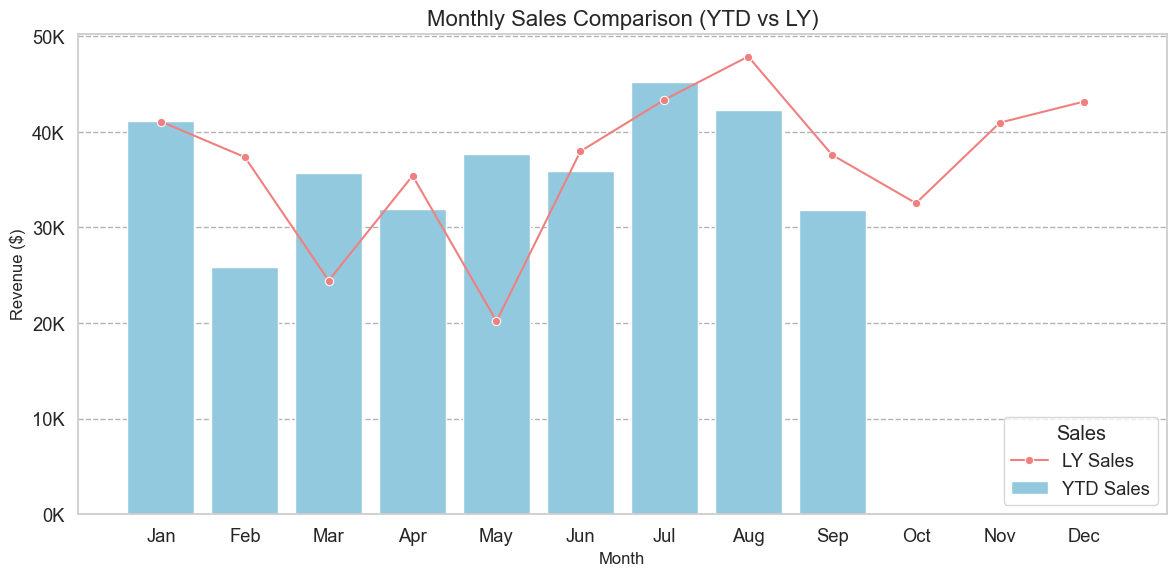


Plotting Cumulative Sales Comparison...


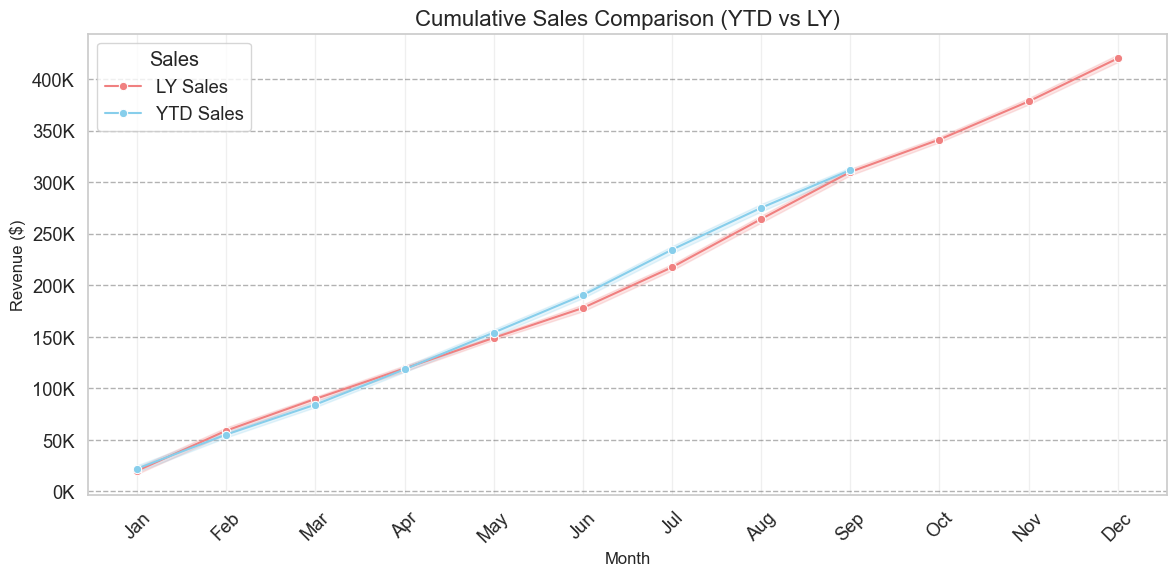


Report generation completed.


In [878]:
# Initialize the SalesTracker class
sales_tracker = SalesTracker(df)

# Run the full report
sales_tracker.generate_full_report()

### Shipment Tracking Feature

In [931]:
class ShipmentStatusAnalysis(Filter):
    def __init__(self, df):
        super().__init__(df)

    def count_shipment_status(self):
        """
        Count the number of orders for each shipment status.
        :return: DataFrame with shipment status counts.
        """
        # Filter the data for current YTD
        current_ytd_data = self.filter_current_ytd_data()

        # Count the shipment status for current YTD data
        shipment_status_count = current_ytd_data['shipment_status'].value_counts()
        return shipment_status_count

    def plot_shipment_status(self):
        """
        Plot a pie chart of shipment status distribution.
        """
        shipment_status_count = self.count_shipment_status()
        shipment_status_count.plot(kind='pie', title="Shipment Status Distribution (YTD)", autopct='%1.1f%%')
        plt.ylabel('')  # Hide y-label for cleaner pie chart
        plt.show()

    def average_time_to_ship_by_carrier(self):
        """
        Calculate the average time taken to ship by each carrier using only current YTD data.
        :return: DataFrame with average shipping time for each carrier.
        """
        # Filter the data for current YTD
        current_ytd_data = self.filter_current_ytd_data()

        # Ensure that order_date and shipment_date are datetime objects
        current_ytd_data['order_date'] = pd.to_datetime(current_ytd_data['order_date'])
        current_ytd_data['shipment_date'] = pd.to_datetime(current_ytd_data['shipment_date'])

        # Calculate the time difference (days) between order date and shipment date
        current_ytd_data['shipping_time'] = (current_ytd_data['shipment_date'] - current_ytd_data['order_date']).dt.days

        # Group by carrier and calculate the average shipping time
        avg_shipping_time = current_ytd_data.groupby('carrier')['shipping_time'].mean().sort_values(ascending=False)
        return avg_shipping_time

    def plot_average_time_to_ship(self):
        """
        Plot a bar chart of the average time to ship by carrier for current YTD data.
        """
        avg_shipping_time = self.average_time_to_ship_by_carrier()

        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=avg_shipping_time.index, y=avg_shipping_time.values, color='lightgreen')

        # Add labels and title
        plt.title("Average Time to Ship by Carrier (YTD)", fontsize=16)
        plt.xlabel('Carrier', fontsize=14)
        plt.ylabel('Average Time to Ship (Days)', fontsize=14)

        # Display the value of each bar above the bar
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

        # Show the plot
        plt.tight_layout()
        plt.show()

    def analyze_shipment_performance(self):
        """
        This method calls all the other methods in the class to analyze and visualize the shipment performance.
        It provides a comprehensive view by:
        - Plotting shipment status distribution.
        - Plotting average time to ship by carrier.
        - Displaying the shipment performance summary table.
        """
        # Calling individual methods to generate insights
        print("Analyzing Shipment Status Distribution YTD...")
        self.plot_shipment_status()
        
        print("Analyzing Average Time to Ship by Carrier...")
        self.plot_average_time_to_ship()
        
        print("Shipment Performance Analysis Complete.")

Analyzing Shipment Status Distribution YTD...


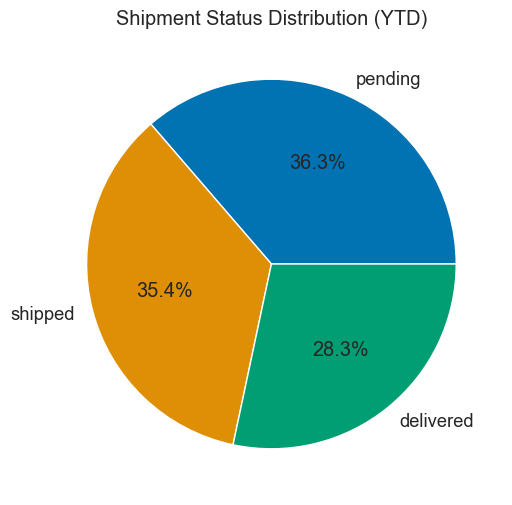

Analyzing Average Time to Ship by Carrier...


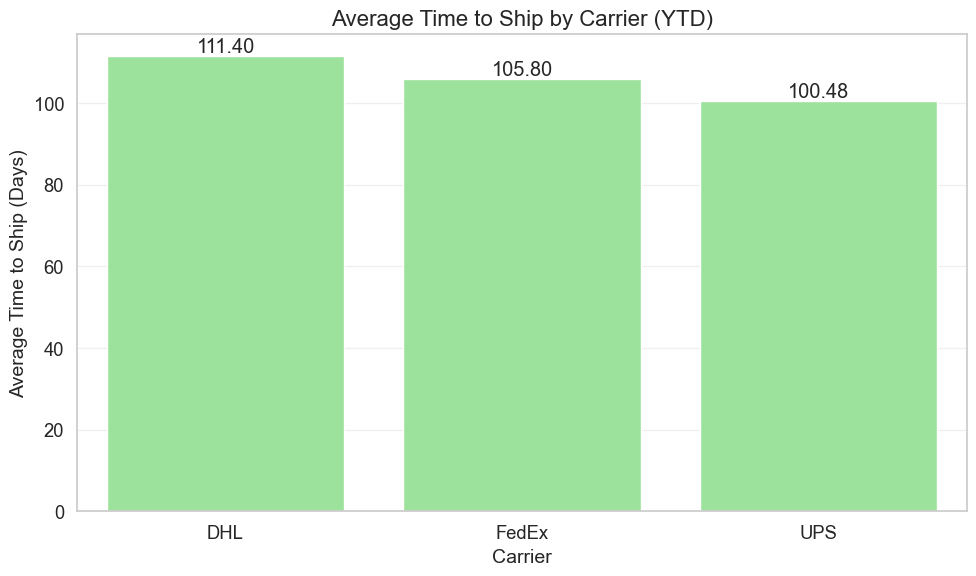

Shipment Performance Analysis Complete.


In [932]:
# Create an instance of the ShipmentStatusAnalysis class
shipment_analysis = ShipmentStatusAnalysis(df)

# Call the method that performs all analyses
shipment_analysis.analyze_shipment_performance()

### Payment Tracking Feature

In [915]:
class PaymentMethodAnalysis(Filter):
    def __init__(self, df):
        super().__init__(df)

    def generate_payment_method_report(self):
        """
        Summarize revenue distribution by payment method using only current YTD data.
        :return: DataFrame with total revenue per payment method.
        """
        # Filter the data for current YTD
        current_ytd_data = self.filter_current_ytd_data()

        # Generate the payment method report using current YTD data
        payment_method_report = current_ytd_data.groupby('payment_method').agg(
            total_revenue=('total_price', 'sum')
        ).reset_index()
        return payment_method_report

    def plot_payment_method_distribution(self):
        """
        Plot a bar chart and a pie chart of revenue distribution by payment method using current YTD data.
        """
        payment_method_report = self.generate_payment_method_report()
        
        # Pie Chart with custom styling
        plt.figure(figsize=(8, 5))
        colors = sns.color_palette('Set2', n_colors=len(payment_method_report))  # Color palette for distinction
        plt.pie(
            payment_method_report['total_revenue'],
            labels=payment_method_report['payment_method'],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'black'}
        )
        plt.title("Payment Method Total Revenue Distribution (YTD)", fontsize=16)
        plt.ylabel("")  # Hide the y-label
        plt.tight_layout()

        plt.show()

    def payment_method_share_by_category(self):
        """
        Creates a clustered bar chart to analyze payment method revenue share across categories.
        """

        pivot_table = pd.pivot_table(self.filter_current_ytd_data(), values='revenue', 
                                     index='category', columns='payment_method', 
                                     aggfunc='sum', fill_value=0)
        
        # Plotting the clustered bar chart
        pivot_table.plot(kind='bar', figsize=(12, 6), colormap='Set2')
        
        plt.title("Payment Method Revenue Share by Category (YTD)", fontsize=16)
        plt.xlabel("Category", fontsize=14)
        plt.ylabel("Revenue", fontsize=14)
        plt.legend(title='Payment Method', bbox_to_anchor=(1, 1), loc='upper left')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
        plt.grid(axis='y', linestyle='--', color='black')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def perform_payment_method_analysis(self):
        """
        Runs all methods to generate and visualize payment method analysis.
        """
        print("Starting Payment Method Analysis...")

        # Generate payment method report
        self.generate_payment_method_report()

        # Plot the payment method distribution
        print("\nPlotting Payment Method Distribution by Revenue YTD...")
        self.plot_payment_method_distribution()

        # Plot payment method share by category
        print("\nPlotting Payment Method Revenue Share by Category...")
        self.payment_method_share_by_category()

        print("Payment Method Analysis Completed.")

Payment Method Share by Category	Analyze which payment methods are preferred within specific product categories.	- Optimize payment method availability for high-revenue categories.
Identify payment methods that are category-specific.	- Target category-specific promotions (e.g., bundle discounts).

1. Monthly Payment Method Usage (Trends Over Time)	Understand trends and seasonality in payment method usage over time.	- Allocate resources to support popular payment methods during peak months.
Identify payment methods gaining/losing popularity.	- Promote underused payment methods through offers or discounts.

A pie chart can quickly identify over-reliance on one payment method, highlighting operational risks if the provider increases fees or experiences outages.

 Focus marketing and operational efforts on methods driving the most revenue.

Starting Payment Method Analysis...

Plotting Payment Method Distribution by Revenue YTD...


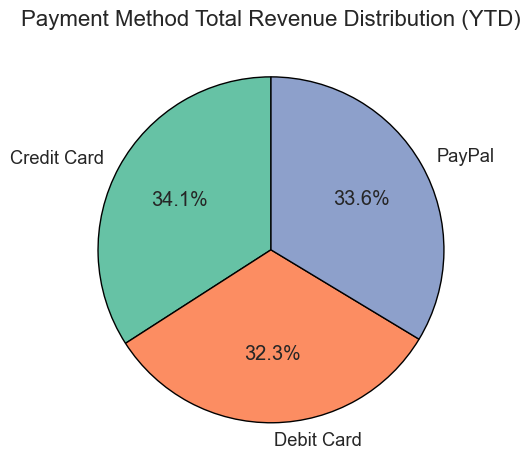


Plotting Payment Method Revenue Share by Category...


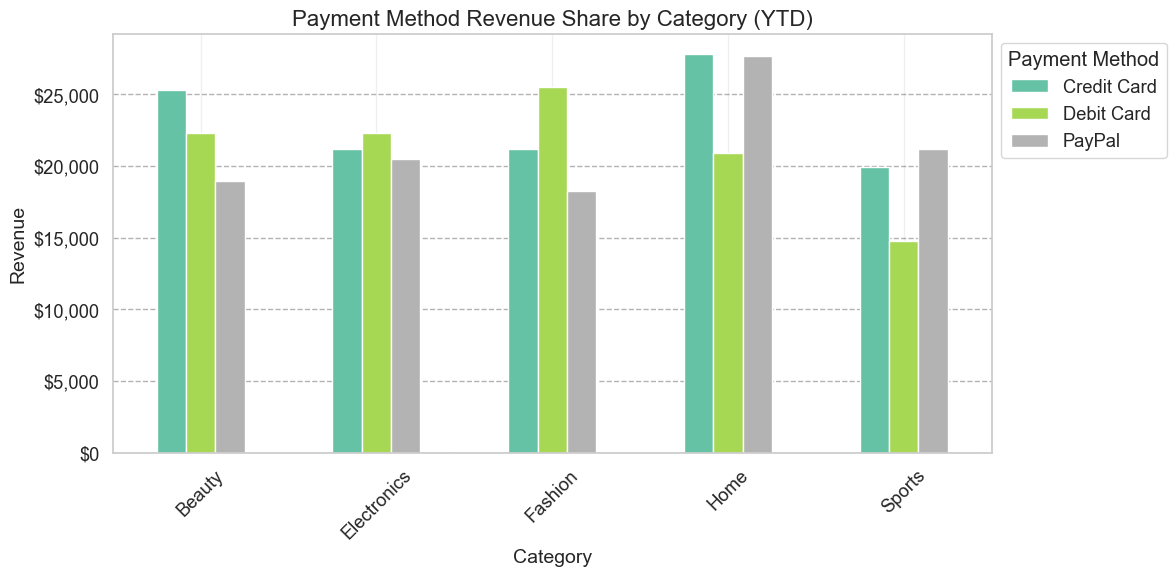

Payment Method Analysis Completed.


In [916]:
# Payment Method Analysis
payment_analysis = PaymentMethodAnalysis(df)

# Perform Payment Method Analysis
perform_payment_method_analysis(payment_analysis)

### Product Performance Analysis Feature

In [912]:
class ProductPerformanceAnalysis(Filter):
    def __init__(self, df):
        """
        Initializes the ProductPerformanceAnalysis class, which inherits from Filter.
        :param df: DataFrame containing sales data.
        """
        super().__init__(df)  # Initialize the Filter class

    def plot_top_products(self, top_n=10, metric='revenue'):
        """
        Plot the top N products by revenue or quantity for the current YTD.
        :param top_n: Number of top products to plot.
        :param metric: Metric to analyze ('revenue' or 'quantity').
        """
        # Use the inherited method to filter YTD data
        ytd_data = self.filter_current_ytd_data()

        if metric == 'revenue':
            # Calculate revenue for each product
            ytd_data['revenue'] = ytd_data['total_price'] * ytd_data['quantity']
            # Group by product and category, then calculate total revenue
            performance_data = ytd_data.groupby(['product_name', 'category'])['revenue'].sum().reset_index()
        elif metric == 'quantity':
            # Group by product and category, then calculate total quantity
            performance_data = ytd_data.groupby(['product_name', 'category'])['quantity'].sum().reset_index()
        else:
            raise ValueError("Metric must be either 'revenue' or 'quantity'")

        # Sort by the metric (revenue or quantity) in descending order and get the top N
        top_products = performance_data.sort_values(by=metric, ascending=False).head(top_n)

        # Plot the top N products
        plt.figure(figsize=(12, 6))
        sns.barplot(x=metric, y='product_name', data=top_products, palette='Set2', hue='category')

        # Add labels and title
        plt.title(f'Top {top_n} Products by {metric.capitalize()} (YTD)')
        plt.xlabel(f'{metric.capitalize()}')
        plt.ylabel('Product Name')

        # Add legend outside the plot to avoid overlapping bars
        plt.legend(title='Category', loc='upper left', bbox_to_anchor=(1, 1))

        # Format the x-axis to show currency for revenue
        if metric == 'revenue':
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
        
        # Adjust layout to make space for the legend
        plt.tight_layout()

        # Show the plot
        plt.show()

#### Subclass: ProductRevenuePerformance

In [914]:
class ProductRevenuePerformance(ProductPerformanceAnalysis):
    def __init__(self, df):
        """
        Initializes the ProductRevenuePerformance class, which inherits from ProductPerformanceAnalysis.
        :param df: DataFrame containing sales data.
        """
        super().__init__(df)

    def plot_top_products_by_revenue(self, top_n=10):
        """
        Plot the top N products by revenue for the current YTD.
        :param top_n: Number of top products to plot.
        """
        self.plot_top_products(top_n=top_n, metric='revenue')

#### Subclass: ProductVolumePerformance

In [ ]:
class ProductVolumePerformance(ProductPerformanceAnalysis):
    def __init__(self, df):
        """
        Initializes the ProductVolumePerformance class, which inherits from ProductPerformanceAnalysis.
        :param df: DataFrame containing sales data.
        """
        super().__init__(df)

    def plot_top_products_by_volume(self, top_n=10):
        """
        Plot the top N products by volume (quantity) for the current YTD.
        :param top_n: Number of top products to plot.
        """
        self.plot_top_products(top_n=top_n, metric='quantity')

"In this implementation, the ProductPerformanceAnalysis class serves as the base class for analyzing product performance, specifically by revenue and quantity (volume). The two subclasses, ProductRevenuePerformance and ProductVolumePerformance, inherit from the base class and focus on specific metrics (revenue and quantity, respectively). This design allows for code reuse and modularity.

The use of inheritance ensures that common logic for filtering and processing the data is centralized in the parent class, while the subclasses handle specific plotting needs based on different performance metrics. This approach follows the principles of object-oriented programming, such as modularity and reusability, which contribute to better maintainability and scalability. Each class and subclass is organized in its own section of the code to improve readability and ease of maintenance, making it easier to extend in the future."

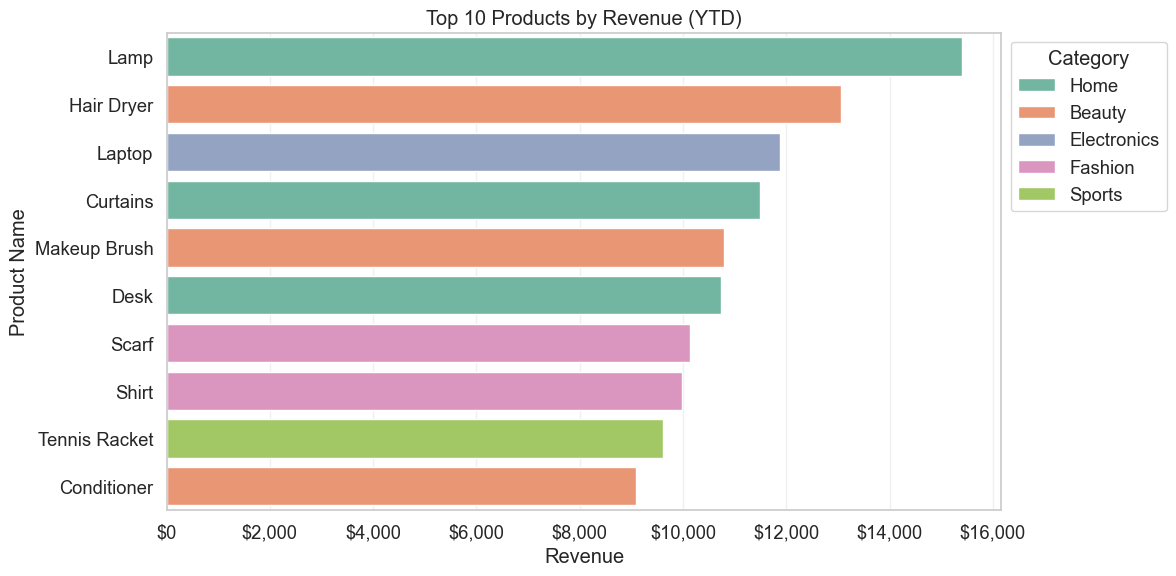

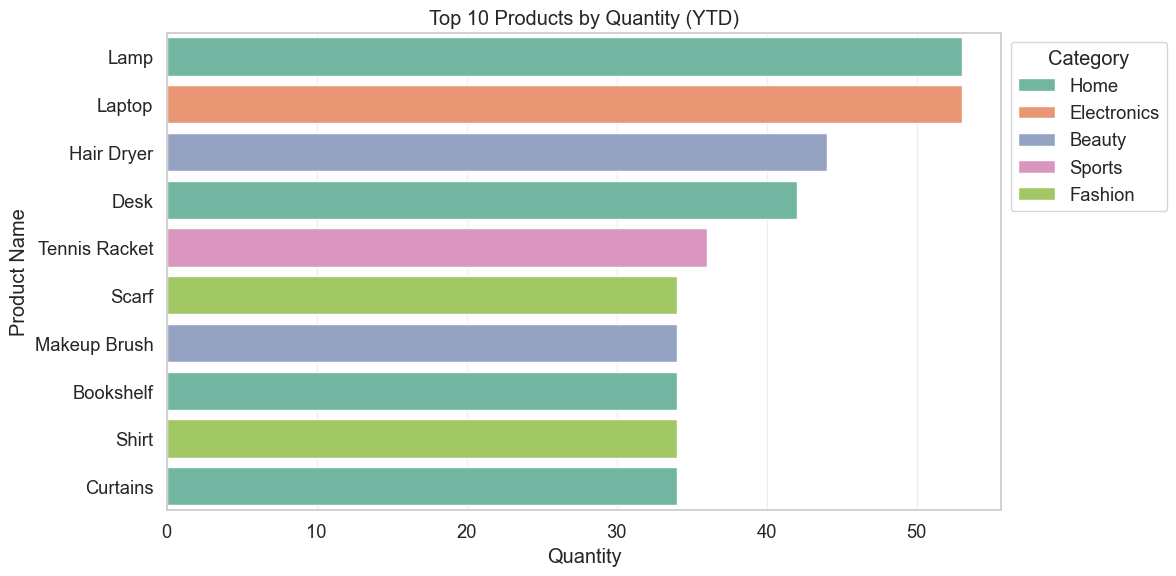

In [913]:
# Initialize the revenue analysis class with the DataFrame
revenue_analysis = ProductRevenuePerformance(df)
revenue_analysis.plot_top_products_by_revenue(top_n=10)  # Plot top 10 products by revenue

# Initialize the volume analysis class with the DataFrame
volume_analysis = ProductVolumePerformance(df)
volume_analysis.plot_top_products_by_volume(top_n=10)  # Plot top 10 products by volume


### Rating Analysis Feature

In [720]:

class ProductRatingAnalysis(Filter):
    def __init__(self, df):
        """
        Initializes the ProductRatingAnalysis class, inheriting from Filter.
        :param df: DataFrame containing order data with columns like 'product_name', 'rating', etc.
        """
        super().__init__(df)  # Call the constructor of the Filter base class

    def calculate_average_rating(self):
        """
        Calculate the average rating for each product for the current YTD.
        :return: DataFrame with average ratings by product.
        """
        # Use the inherited method to filter YTD data
        ytd_data = self.filter_current_ytd_data()
        
        # Group by product_name and calculate the average rating
        product_avg_rating = ytd_data.groupby('product_name')['rating'].mean().reset_index()
        return product_avg_rating

    def partition(self, data, low, high, ascending=False):
        """
        Helper method for the Quick Sort algorithm. It partitions the data around a pivot.
        :param data: DataFrame or list to be partitioned.
        :param low: The starting index.
        :param high: The ending index.
        :param ascending: Whether to sort in ascending order. If False, sorts in descending order.
        :return: The index of the pivot after partitioning.
        """
        pivot = data.iloc[high]['rating']  # Taking the last element as the pivot
        i = low - 1  # Index of the smaller element
        for j in range(low, high):
            if (data.iloc[j]['rating'] < pivot and ascending) or (data.iloc[j]['rating'] > pivot and not ascending):  # Adjusted for ascending/descending
                i += 1
                data.iloc[i], data.iloc[j] = data.iloc[j], data.iloc[i]  # Swap elements
        data.iloc[i + 1], data.iloc[high] = data.iloc[high], data.iloc[i + 1]  # Place pivot in correct position
        return i + 1
    
    def quick_sort(self, data, low, high, ascending=False):
        """
        Quick Sort algorithm to sort the data by rating.
        :param data: DataFrame or list to be sorted.
        :param low: The starting index of the portion to be sorted.
        :param high: The ending index of the portion to be sorted.
        :param ascending: Whether to sort in ascending order. If False, sorts in descending order.
        :return: Sorted DataFrame or list.
        """
        if low < high:
            # Partition the data
            pi = self.partition(data, low, high, ascending)
            # Recursively sort the left and right parts
            self.quick_sort(data, low, pi - 1, ascending)
            self.quick_sort(data, pi + 1, high, ascending)

        return data

    def plot_top_rated(self, top_n=5, highest=True):
        """
        Plot the top 'n' highest or lowest-rated products using Seaborn.
        :param top_n: Number of top-rated or lowest-rated products to plot.
        :param highest: Whether to plot the highest-rated (True) or lowest-rated (False) products.
        """
        # Calculate the average ratings for each product
        product_avg_rating = self.calculate_average_rating()

        # Sort products by average rating using Quick Sort
        ascending = not highest  # If highest, sort in descending; if lowest, sort in ascending
        product_avg_rating = self.quick_sort(product_avg_rating, 0, len(product_avg_rating) - 1, ascending)

        # Select the top 'n' highest or lowest rated products
        top_rated = product_avg_rating.head(top_n)

        # Plot the top 'n' highest or lowest-rated products using Seaborn
        plt.figure(figsize=(12, 6))
        color = 'green' if highest else 'red'
        ax = sns.barplot(x='product_name', y='rating', data=top_rated, color=color)

        # Add labels and title
        title = f"Top {top_n} {'Highest' if highest else 'Lowest'} Rated Products YTD"
        plt.title(title, fontsize=16)
        plt.xlabel("Product")
        plt.xticks(rotation=45)
        plt.ylabel("Average Rating")

        # Display the value of each bar above the bar
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()


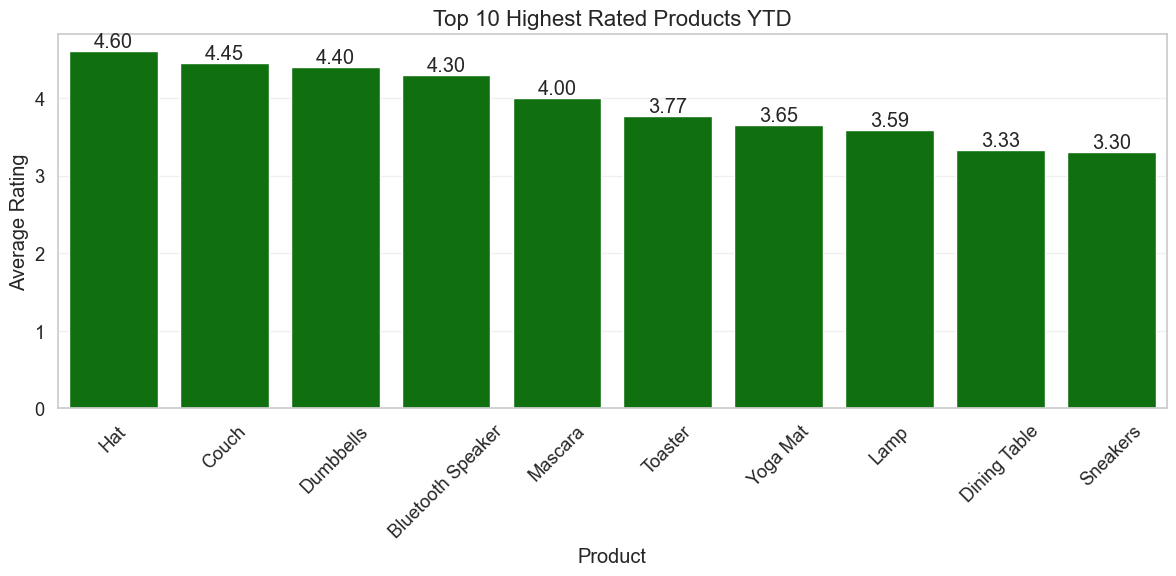

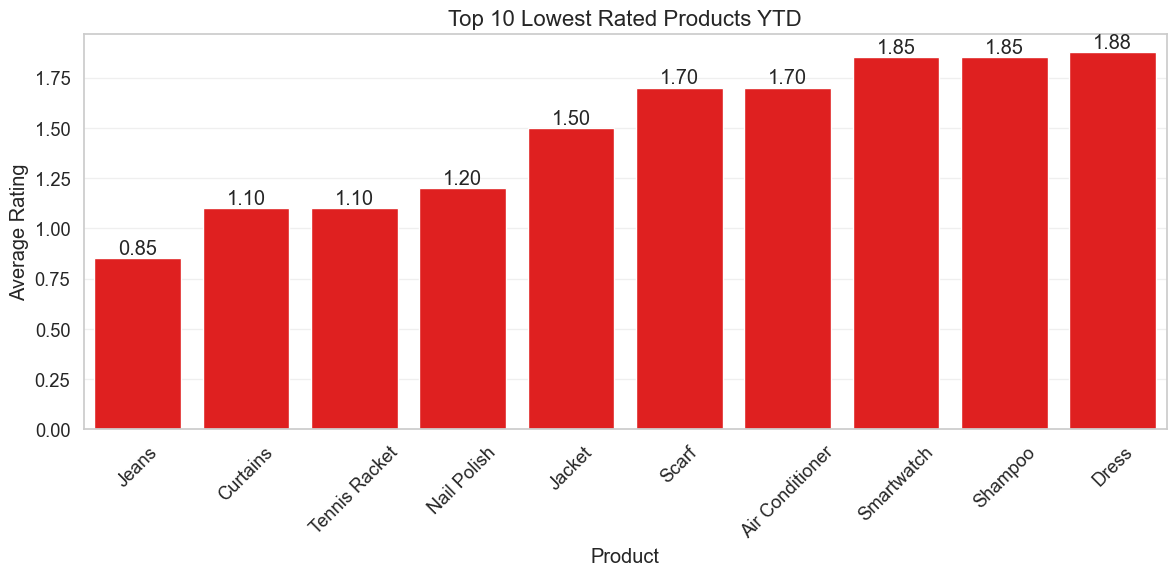

In [920]:
# Initialize the ProductRatingAnalysis class
product_analysis = ProductRatingAnalysis(df)

# Plot the top 10 highest and lowest rated products
product_analysis.plot_top_rated(top_n=10, highest=True)
product_analysis.plot_top_rated(top_n=10, highest=False)

### Category Revenue Feature

In [919]:
class CategoryRevenueAnalysis(Filter):
    def __init__(self, df):
        """
        Initializes the CategoryRevenueAnalysis class, inheriting from Filter.
        :param df: DataFrame containing order data with columns like 'category', 'revenue', and 'order_date'.
        """
        super().__init__(df)  # Call the constructor of the Filter base class

    def prepare_ytd_ly_data(self):
        """
        Prepares the YTD and LY data for cumulative revenue comparison.
        :return: YTD and LY data for plotting.
        """
        # Filter YTD and LY data
        ytd_data = self.filter_current_ytd_data()
        ly_data = self.filter_ly_data()

        ytd_data = ytd_data[ytd_data['order_date'].dt.month <= 9].copy()
        ytd_data['month'] = ytd_data['order_date'].dt.month  # Extract month (1-12)
        ytd_data = ytd_data.sort_values('order_date')
        ytd_data['cumulative_sales'] = ytd_data.groupby('category')['revenue'].cumsum()  # Cumulative sum for current year

        # For LY (Full year, January to December)
        ly_data['month'] = ly_data['order_date'].dt.month  # Extract month (1-12)
        ly_data = ly_data.sort_values('order_date')
        ly_data['cumulative_sales'] = ly_data.groupby('category')['revenue'].cumsum()  # Cumulative sum for LY

        return ytd_data, ly_data

    def plot_cumulative_sales_ytd_vs_ly(self):
        """
        Plots cumulative sales by category for YTD vs LY, with each category in a separate subplot.
        """
        try:
            # Prepare the YTD and LY data for plotting
            ytd_data, ly_data = self.prepare_ytd_ly_data()

            # Get unique categories
            categories = self.df['category'].unique()

            # Set up the figure for subplots (5 rows and 1 column)
            plt.figure(figsize=(15, len(categories) * 4))  # Adjust height based on number of categories

            # Plot each category in a separate subplot
            for idx, category in enumerate(categories, start=1):
                # Filter data for the current category
                category_ytd = ytd_data[ytd_data['category'] == category]
                category_ly = ly_data[ly_data['category'] == category]

                # Create a subplot for each category
                plt.subplot(len(categories), 1, idx)

                # Plot YTD cumulative sales as a line
                sns.lineplot(x='month', y='cumulative_sales', data=category_ytd, label=f'YTD {category}', color='blue', marker='o')

                # Plot LY cumulative sales as a line
                sns.lineplot(x='month', y='cumulative_sales', data=category_ly, label=f'LY {category}', color='red', marker='o')

                # Set title and labels
                plt.title(f'Cumulative Sales Comparison: {category} (YTD vs LY)', fontsize=14)
                plt.xlabel('Month')
                plt.ylabel('Revenue ($)')
                plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

                # Format y-axis
                plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

                # Add grid lines
                plt.grid(axis='y', linestyle='--', color='black')

                # Show legend
                plt.legend()

            # Adjust layout and show the plot
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error in plotting cumulative sales: {e}")

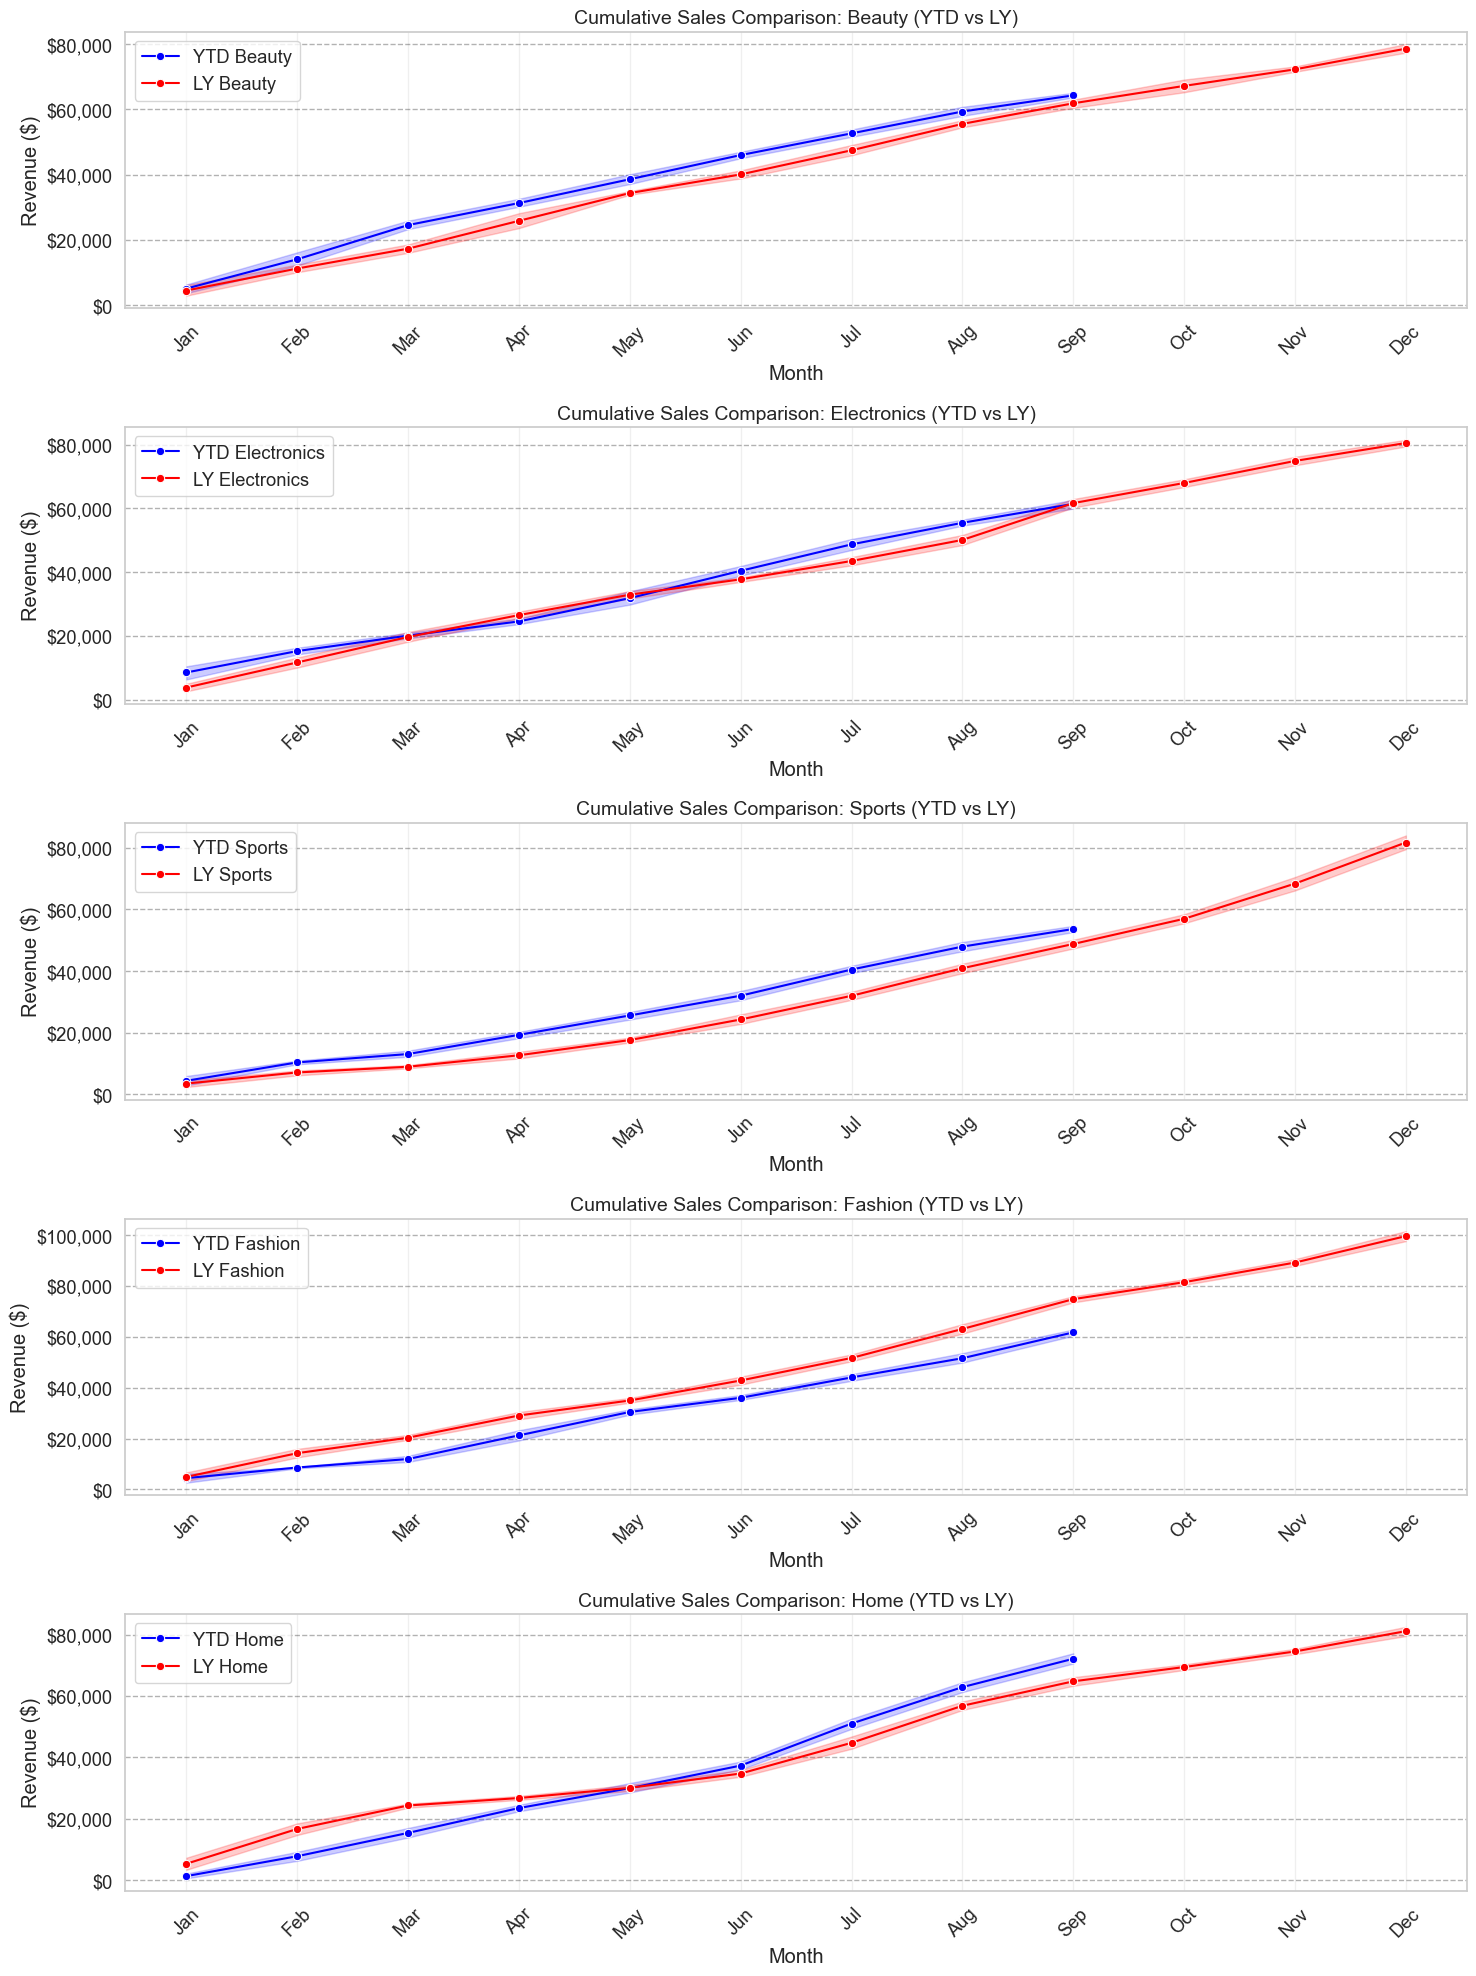

In [918]:
# Initialize the CategoryRevenueAnalysis class
category_revenue_analysis = CategoryRevenueAnalysis(df)

# Plot cumulative sales for YTD vs LY by category
category_revenue_analysis.plot_cumulative_sales_ytd_vs_ly()